In [1]:
dstype = 'cc' 
mname = 'debertaV3'

In [2]:
 
modelpath = 'microsoft/deberta-v3-base'
# modelpath = "bert-base-uncased"


datapath = None
saveDIR = f"/home/bhairavi/om/om5/{dstype}/{mname}_{dstype}"
print(saveDIR)
# %%

/home/bhairavi/om/om5/cc/debertaV3_cc


In [3]:
modelpath = saveDIR

In [4]:


# %%
# %%
 
import os
import torch  

torch.cuda.empty_cache() 

import pandas as pd
from datasets import Dataset, DatasetDict, load_metric
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
 

 


# %%
 


/home/bhairavi/om/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
df = pd.read_csv('/home/bhairavi/om/om5/cc/cc.csv')

In [6]:

# %%

# %%
df.sample(5)


# %%


,Unnamed: 0,Product,Consumer_complaint,category_id
297599,699160,"Credit reporting, repair, or other",I have credit monitoring services with several...,0
382039,908339,Debt collection,I hav received multiple calls a day on my home...,1
170698,415530,"Credit reporting, repair, or other",Equifax did not properly secure my protected p...,0
172763,419554,"Credit reporting, repair, or other",Equifax mishandled my information which has le...,0
214138,503443,Mortgage,I have a Mort gage Loan with Wells Fargo. Bec ...,3


In [7]:
df.drop(columns=["Unnamed: 0"], inplace=True)
df.columns = (['label','text','target'])


13

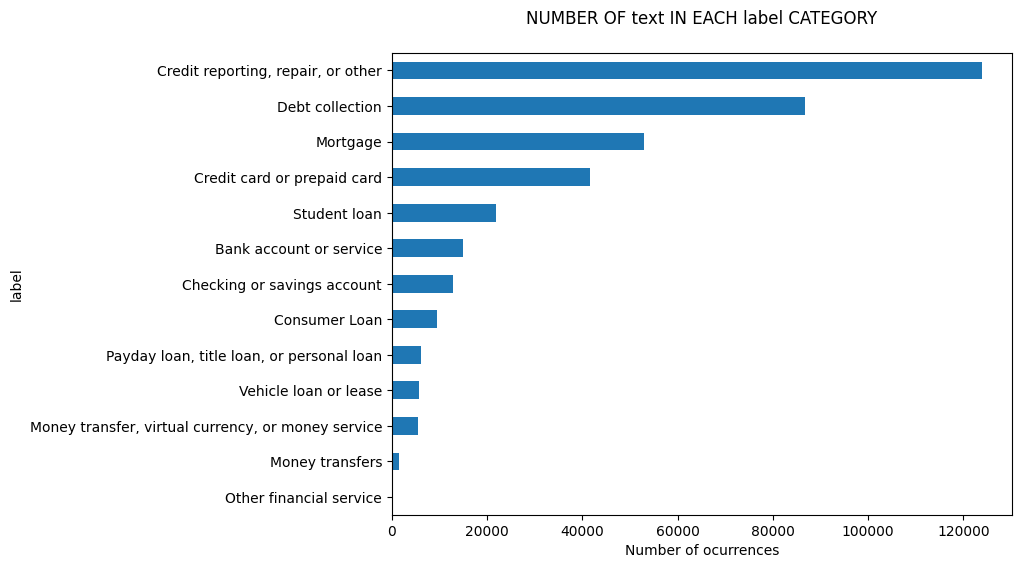

In [8]:


# %%

# %%
from sklearn.preprocessing import LabelEncoder

# %%
le = LabelEncoder()
df['target'] = le.fit_transform(df['label'])

# %%



# %%

# %%
fig = plt.figure(figsize=(8,6)) 
df.groupby('label').text.count().sort_values().plot.barh(
    ylim=0,   title= 'NUMBER OF text IN EACH label CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);


# %%


# %%

# %%
numlabel = df['target'].nunique()
numlabel


In [9]:
df.columns

Index(['label', 'text', 'target'], dtype='object')

In [10]:
numlabel = df['target'].nunique()
numlabel


13

In [11]:
df['text'] = df['text'].apply(lambda x: x[:512])

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

device = "cuda"  # the device to load the model onto

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(modelpath)
model = AutoModelForSequenceClassification.from_pretrained(modelpath, num_labels=numlabel)

# Move the model to the specified device
model.to(device)

DebertaV2ForSequenceClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 768, padding_idx=0)
      (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine=True)
      (dropout): StableDropout()
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-11): 12 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=768, out_features=768, bias=True)
              (key_proj): Linear(in_features=768, out_features=768, bias=True)
              (value_proj): Linear(in_features=768, out_features=768, bias=True)
              (pos_dropout): StableDropout()
              (dropout): StableDropout()
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-07, elementwise_affine

In [13]:
# df['token_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

# # Calculate the maximum token length
# max_length = df['token_length'].max()

# # Calculate the next maximum token length
# next_max_token_length = df['token_length'].nlargest(2).iloc[1]

# # Calculate the average token length
# average_token_length = df['token_length'].mean()

# # Display the results
# print(f"Maximum token length: {max_length}")
# print(f"Next maximum token length: {next_max_token_length}")
# print(f"Average token length: {average_token_length:.2f}")

In [14]:
max_length = 512

In [15]:

# %%
from sklearn.model_selection import StratifiedShuffleSplit

# Splitting off the test set with 5% of the data
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # 5% for test
for train_val_idx, test_idx in sss.split(df, df['target']):
    train_val_df = df.iloc[train_val_idx]
    test_df = df.iloc[test_idx]

# Further split train_val_df into train and validation sets with validation set being 15.79% of the remaining data
# (which is equivalent to 15% of the original dataset size)
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)  # ~15.79% of remaining data
for train_idx, val_idx in sss_val.split(train_val_df, train_val_df['target']):
    train_df = train_val_df.iloc[train_idx]
    val_df = train_val_df.iloc[val_idx]
 

def tokenize_and_format(examples):
    # Tokenize the texts
    tokenized_inputs = tokenizer(examples['text'], padding="max_length", truncation=True, max_length=max_length)
    tokenized_inputs['label'] = list(map(int, examples['target']))
    return tokenized_inputs

# Convert pandas DataFrame to Hugging Face's Dataset
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(val_df) 
test_dataset = Dataset.from_pandas(test_df)

# Map the tokenization function across the datasets
train_dataset = train_dataset.map(tokenize_and_format, batched=True,batch_size=16)
eval_dataset = eval_dataset.map(tokenize_and_format, batched=True,batch_size=16) 
test_dataset = test_dataset.map(tokenize_and_format, batched=True,batch_size=16)




Map: 100%|██████████| 19179/19179 [00:08<00:00, 2324.26 examples/s]


In [16]:


# %%
from sklearn.metrics import f1_score, precision_score, recall_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    return {
        'eval_f1': f1,
        'eval_precision': precision,
        'eval_recall': recall,
    }

 


# %%

# %%
 

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # Use 'epoch' to evaluate at the end of each epoch
    save_strategy="epoch",  # Also use 'epoch' to save at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,  # Load the best model at the end of training based on metric
    metric_for_best_model='f1',  # Define the metric for evaluating the best model
    logging_dir='./logs',
    logging_steps=10,
    report_to=[] 
)


 

trainer = Trainer(
    model=model,
    args=training_args ,  # Here you will need to make sure that the Trainer is set up correctly
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)

# Start training
trainer.train()

 
 



/home/bhairavi/om/lib/python3.10/site-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,F1,Precision,Recall
1,0.220500,0.711165,0.850157,0.850302,0.851769


KeyboardInterrupt: 

In [17]:
save_directory = saveDIR
 

# Save the model
model.save_pretrained(save_directory)

# Save the tokenizer (optional, but recommended)
tokenizer.save_pretrained(save_directory)

('/home/bhairavi/om/om5/cc/debertaV3_cc/tokenizer_config.json',
 '/home/bhairavi/om/om5/cc/debertaV3_cc/special_tokens_map.json',
 '/home/bhairavi/om/om5/cc/debertaV3_cc/spm.model',
 '/home/bhairavi/om/om5/cc/debertaV3_cc/added_tokens.json',
 '/home/bhairavi/om/om5/cc/debertaV3_cc/tokenizer.json')

In [18]:

# %%
from colorama import Fore, Style


# %% [markdown]
# eval dataset performance so that keywords_classes can be fixed

# %%
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(eval_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)
print(Fore.CYAN,"keywords class evaluation detection RESULTS")
print(report)


# %% [markdown]
# skyline

# %%


 keywords class evaluation detection RESULTS
                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other     0.7189    0.6247    0.6685      2121
                                   Debt collection     0.6745    0.7222    0.6975      1836
                                      Student loan     0.6438    0.5156    0.5726      1350
                                          Mortgage     0.7921    0.8606    0.8249      5938
                       Credit card or prepaid card     0.9079    0.8967    0.9023     17665
                       Checking or savings account     0.8531    0.8675    0.8602     12356
Money transfer, virtual currency, or money service     0.7604    0.7478    0.7540       781
                             Vehicle loan or lease     0.5440    0.6385    0.5875       213
         Payday loan, title loan, or personal loan     0.9250    0.9435    0.9341      7551
                           Bank ac

In [ ]:


# %%
print(Fore.RED +"TEST DATA IS OUR SKYLINE RESULT")
 
results = trainer.evaluate()

# Predict using the trained model to get labels and predictions
predictions, labels, _ = trainer.predict(test_dataset)
predictions = np.argmax(predictions, axis=1)


# %%
from sklearn.metrics import classification_report
# Generate the classification report
report = classification_report(
    labels,
    predictions,
    target_names=df['label'].unique() , # Adjust this line as per your dataset
    digits=4
)

print(report)


TEST DATA IS OUR SKYLINE RESULT


/home/bhairavi/om/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                    precision    recall  f1-score   support

                Credit reporting, repair, or other     0.6968    0.6949    0.6958       744
                                   Debt collection     0.7291    0.6646    0.6954       644
                                      Student loan     0.6241    0.5781    0.6002       474
                                          Mortgage     0.8025    0.8483    0.8247      2083
                       Credit card or prepaid card     0.9067    0.8997    0.9032      6199
                       Checking or savings account     0.8667    0.8665    0.8666      4336
Money transfer, virtual currency, or money service     0.7667    0.7555    0.7610       274
                             Vehicle loan or lease     0.5309    0.5733    0.5513        75
         Payday loan, title loan, or personal loan     0.9258    0.9513    0.9384      2649
                           Bank account or service     0.0000    0.0000    0.00